

# Object detection with Intel® Distribution of OpenVINO™ toolkit

This tutorial uses a Single Shot MultiBox Detector (SSD) on a trained mobilenet-ssd* model to walk you through the basic steps of using two key components of the Intel® Distribution of OpenVINO™ toolkit: Model Optimizer and Inference Engine.

Model Optimizer is a cross-platform command-line tool that takes pre-trained deep learning models and optimizes them for performance/space using conservative topology transformations. It performs static model analysis and adjusts deep learning models for optimal execution on end-point target devices.

Inference is the process of using a trained neural network to interpret data, such as images. This lab feeds a short video of cars, frame-by-frame, to the Inference Engine which subsequently utilizes an optimized trained neural network to detect cars.





    
## Part 1: Optimize a deep-learning model using the Model Optimizer (MO)

In this section, you will use the Model Optimizer to convert a trained model to two Intermediate Representation (IR) files (one .bin and one .xml). The Inference Engine requires this model conversion so that it can use the IR as input and achieve optimum performance on Intel hardware.


### 1. Importing Dependencies

In [1]:
from IPython.display import HTML
import os
import time
import sys                                     
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent.parent))
from demoTools.demoutils import *

Now, using the model downloader tool we will download the required models that are helpful in this exercise. We will use the **MobileNet-SSD** model. Download the model, specifying the name and output directory.

In [2]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name mobilenet-ssd -o models

################|| Downloading models ||################

========== Downloading models/public/mobilenet-ssd/mobilenet-ssd.prototxt
... 100%, 28 KB, 48176 KB/s, 0 seconds passed

========== Downloading models/public/mobilenet-ssd/mobilenet-ssd.caffemodel
... 100%, 22605 KB, 18308 KB/s, 1 seconds passed

################|| Post-processing ||################



In [3]:
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 


    
### 2. Run the Model Optimizer on the pretrained Caffe* model. This step generates one .xml file and one .bin file and place both files in the tutorial samples directory (located here: /object-detection/)

In [4]:
! python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_caffe.py --input_model models/public/mobilenet-ssd/mobilenet-ssd.caffemodel -o models/mobilenet-ssd/FP32/ --scale 256 --mean_values [127,127,127]

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u33131/13Nov-SVW-R3/object-detection/devcloud/python/models/public/mobilenet-ssd/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u33131/13Nov-SVW-R3/object-detection/devcloud/python/models/mobilenet-ssd/FP32/
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[127,127,127]
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Path to Python Caffe* parser generated from caffe.proto: 	/opt/intel/openvino/deployment_tools/model_optimizer/mo/front/caf



   Note: Although this tutorial uses Single Shot MultiBox Detector (SSD) on a trained mobilenet-ssd* model, the Inference Engine is compatible with other neural network architectures, such as AlexNet*, GoogleNet*, MxNet* etc.


The Model Optimizer converts a pretrained Caffe* model to make it compatible with the Intel Inference Engine and optimizes it for Intel® architecture. These are the files you would include with your C++ application to apply inference to visual data.

   Note: if you continue to train or make changes to the Caffe* model, you would then need to re-run the Model Optimizer on the updated model.

### 3. Navigate to the tutorial sample model directory and verify creation of the optimized model files (the IR files)

In [5]:
!ls models/mobilenet-ssd/FP32/

mobilenet-ssd.bin  mobilenet-ssd.mapping  mobilenet-ssd.xml



    
You should see the following two files listed in this directory: mobilenet-ssd.xml and mobilenet-ssd.bin


## Part 2: Use the mobilenet-ssd* model and Inference Engine in an object detection application


### 1. Open the sample app [tutorial1.py](tutorial1.py)  and view the lines that call the Inference Engine.



    
-   Line 98 — Plugin initialization for specified device and load extensions library if specified
-   Line 105 — initializes the network object
-   Line 120 — Loading IR to the plugin...
-   Line 143 — Read and pre-process input image
-   Line 194 — allocate output blobs


For simplicity of the code and in order to put more focus on the performance number, video rendering with rectangle boxes for detected objects has been separated from main.cpp. 

Here are the parameters used in the above command to run the application:

In [6]:
!python3 tutorial1.py -h

usage: tutorial1.py [-h] -m MODEL -i INPUT [-ce CPU_EXTENSION]
                    [-pp PLUGIN_DIR] [-d DEVICE]
                    [-nireq NUMBER_INFER_REQUESTS] [-s] [-l LABELS]
                    [-pt PROB_THRESHOLD] -o OUTPUT_DIR

optional arguments:
  -h, --help            show this help message and exit
  -m MODEL, --model MODEL
                        Path to an .xml file with a trained model.
  -i INPUT, --input INPUT
                        Path to video file or image. 'cam' for capturing video
                        stream from camera.
  -ce CPU_EXTENSION, --cpu_extension CPU_EXTENSION
                        MKLDNN-targeted custom layers.Absolute path to a
                        shared library with the kernel implementation.
  -pp PLUGIN_DIR, --plugin_dir PLUGIN_DIR
                        Path to a plugin directory.
  -d DEVICE, --device DEVICE
                        Specify the target device to infer on; CPU, GPU, FPGA,
                        MYRIAD, or HDDL is accept

### 3. Source your environmental variables

In [7]:
! /opt/intel/openvino/bin/setupvars.sh
os.environ["VIDEO"] = "cars_1900.mp4"

[setupvars.sh] OpenVINO environment initialized


We will be using the below cars video in this example to detect the cars from the input video.  

In [8]:
videoHTML('Sample Video', 
          ['cars_1900.mp4'])


    
### 4. Run the sample application to use the Inference Engine on the test video

#### Create Job Script 

We will run the workload on several DevCloud's edge compute nodes. We will send work to the edge compute nodes by submitting jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

To pass the specific variables to the Python code, we will use following arguments:

* `-f`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;location of the optimized models XML
* `-i`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;location of the input video
* `-r`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;output directory
* `-d`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;hardware device type (CPU, GPU, MYRIAD, HDDL or HETERO:FPGA,CPU)
* `-n`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;number of infer requests

The job file will be executed directly on the edge compute node.

In [10]:
%%writefile object_detection_end2end.sh

ME=`basename $0`

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

# Object detection script writes output to a file inside a directory. We make sure that this directory exists.
# The output directory is the first argument of the bash script
while getopts 'd:f:i:r:n:?' OPTION; do
    case "$OPTION" in
    d)
        DEVICE=$OPTARG
        echo "$ME is using device $OPTARG"
      ;;

    f)
        FP_MODEL=$OPTARG
        echo "$ME is using floating point model $OPTARG"
      ;;

    i)
        INPUT_FILE=$OPTARG
        echo "$ME is using input file $OPTARG"
      ;;
    r)
        RESULTS_BASE=$OPTARG
        echo "$ME is using results base $OPTARG"
      ;;
    n)
        NUM_INFER_REQS=$OPTARG
        echo "$ME is running $OPTARG inference requests"
      ;;
    esac  
done

NN_MODEL="mobilenet-ssd.xml"
RESULTS_PATH="${RESULTS_BASE}"
mkdir -p $RESULTS_PATH
echo "$ME is using results path $RESULTS_PATH"

# Running the object detection code
SAMPLEPATH=$PBS_O_WORKDIR
python3 tutorial1.py                        -m models/mobilenet-ssd/${FP_MODEL}/${NN_MODEL}  \
                                            -i $INPUT_FILE \
                                            -o $RESULTS_PATH \
                                            -d $DEVICE \
                                            -nireq $NUM_INFER_REQS \
                                            -ce /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so

g++ -std=c++14 ROI_writer.cpp -o ROI_writer  -lopencv_core -lopencv_videoio -lopencv_imgproc -lopencv_highgui  -fopenmp -I/opt/intel/openvino/opencv/include/ -L/opt/intel/openvino/opencv/lib/
# Rendering the output video
SKIPFRAME=1
RESOLUTION=0.5
./ROI_writer $INPUT_FILE $RESULTS_PATH $SKIPFRAME $RESOLUTION

Overwriting object_detection_end2end.sh


In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel 
    Core i5-6500TE</a>. The inference workload will run on the CPU.

In [11]:
#Submit job to the queue
job_id_core = !qsub object_detection_end2end.sh -l nodes=1:idc001skl:tank-870:i5-6500te -F "-r results/Core/ -d CPU -f FP32 -i $VIDEO -n 2" -N obj_det_core
print(job_id_core[0]) 
#Progress indicators
if job_id_core:
    progressIndicator('results/Core', 'pre_progress.txt', "Preprocessing", 0, 100)
    progressIndicator('results/Core', 'i_progress.txt', "Inference", 0, 100)
    progressIndicator('results/Core', 'post_progress.txt', "Rendering", 0, 100)

2390.v-qsvr-1.devcloud-edge


### While you wait...

#### Why do we have three progress indicators for every job? 

In a real-life inference application, the video processing pipeline may have these phases:

1. Preprocessing (such as video decoding, frame capture from camera, or fetching a frame from a network, resizing, cropping, contrast normalization, etc.) The performance of this phase will often depend on the CPU, storage, and networking speed.
2. Inference (running a neural network forward propagation procedure). The performance of inference depends mostly on the compute device (CPU or an accelerator).
3. Postprocessing (feeding data into the next pipeline stage, writing to file, sending it to a database, or even encoding a new video for a human viewer). This phase will often use the CPU, storage, or network, and will not use an accelerator.

In our demonstration samples, we separate these three phases into separate workloads. This separation allows you to independently judge the relative impact of each phase and draw conclusions for your applications. 

#### What does it mean for my application?

Your application may have more or less pre/post-processing work depending on how you get your data (from storage, sensor or network), what is the resolution of your raw data, is it encoded or not, whether you need to produce an output video, etc. Therefore, you need to understand how your processing pipeline relates to this demo before drawing conclusions on performance.

In this demo, we provide three performance numbers for each architecture. However, they are not hard limits on the solution's performance. You need to relate these numbers and code to what you are doing in your own project.

#### The total time is not necessarily equal to the sum of the parts

It is important to realize that in a real-life application, you may want to fuse preprocessing, inference, and postprocessing, as opposed to separating them as we did here. Fused preprocessing has several advantages:
* If inference is run asynchronously on the accelerator, the rest of the system is free for preprocessing future frames or postprocessing past frames. This allows you to mask the pre/post processing time behind inference time. 
* With fused preprocessing, inference and postprocessing, your pipeline has better data locality, allowing you to reuse data in the caches, in the application's memory, or in the hard drive cache. 

### 5. Display output


You should see a video play with cars running on the highway and bounding boxes around them.

In [12]:
videoHTML('IEI Tank (Intel  CPU)', 
          ['results/Core/output.mp4'])


    
## Part 3: Run the example on different hardware



    
In the previous exercise we saw the time it took for inference in CPU, Now we will run the same sample on GPU and see the total time it takes to run the inference.

#### GPU

In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.
    
    
Set target hardware as GPU with -d GPU

In [13]:
#Submit job to the queue
job_id_gpu = !qsub object_detection_end2end.sh -l nodes=1:idc001skl:intel-hd-530 -F "-r results/GPU -d GPU -f FP32 -i $VIDEO -n 4" -N obj_det_gpu 
print(job_id_gpu[0]) 
#Progress indicators
if job_id_gpu:
    progressIndicator('results/GPU', 'pre_progress.txt', "Preprocessing", 0, 100)
    progressIndicator('results/GPU', 'i_progress.txt', "Inference", 0, 100)
    progressIndicator('results/GPU', 'post_progress.txt', "Rendering", 0, 100)

2400.v-qsvr-1.devcloud-edge


In [14]:
videoHTML('IEI Tank (Intel Core GPU)', 
          ['results/GPU/output.mp4'] 
          )


    
The total time between CPU and GPU will vary depending on your system.

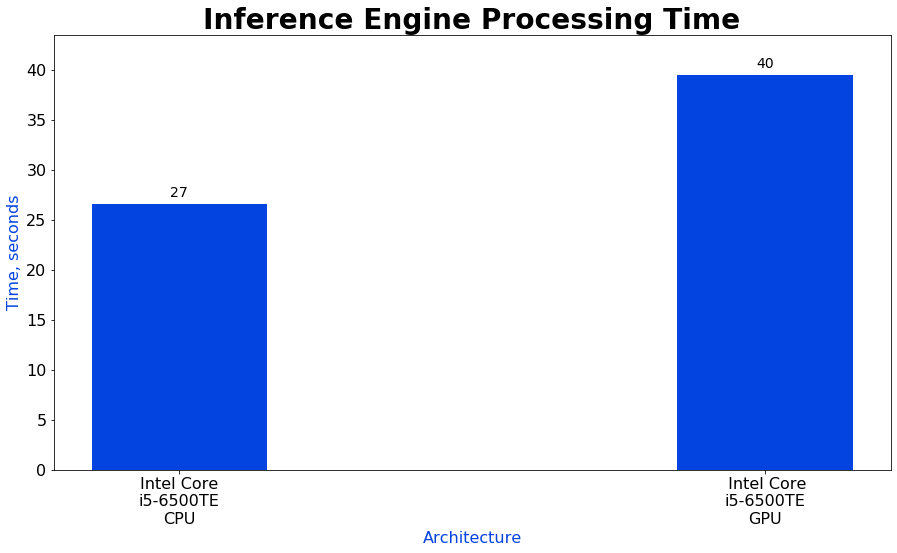

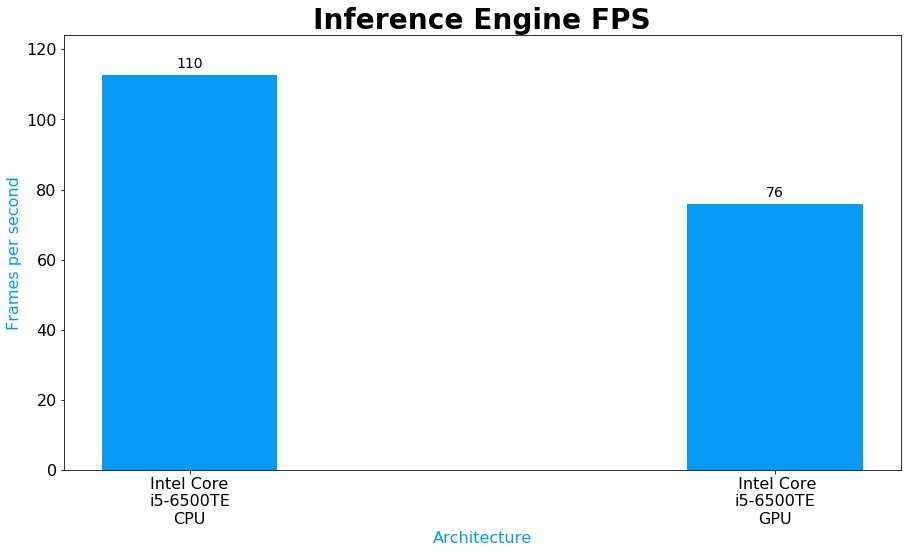

In [15]:
arch_list = [('Core', 'Intel Core\ni5-6500TE\nCPU'),
             ('GPU', ' Intel Core\ni5-6500TE\nGPU')]
stats_list = []
for arch, a_name in arch_list:
    stats_list.append(('results/{arch}/stats.txt'.format(arch=arch), a_name))
    
summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time', 0.3 )
summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps', 0.3 )